In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# CBAM Attention Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)
        sa_input = torch.cat([max_out, mean_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

# EfficientNet-B0 + CBAM model
class BreastNetPP(nn.Module):
    def __init__(self):
        super(BreastNetPP, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.cbam = CBAM(1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.cbam(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.sigmoid(self.fc2(x))


In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['benign', 'malignant']
        self.image_paths = []
        self.labels = []

        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, torch.tensor(label, dtype=torch.float32)


In [3]:
train_transform = A.Compose([
    A.Resize(160, 160),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(160, 160),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [4]:
train_dataset = CustomDataset("./Preprocessed/train", transform=train_transform)
val_dataset = CustomDataset("./Preprocessed/val", transform=val_transform)
test_dataset = CustomDataset("./Preprocessed/test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BreastNetPP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Loaded pretrained weights for efficientnet-b0


In [6]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# Shared Results Dictionary
results = {}

# BreastNet++ Evaluation (uses sigmoid)
def test_breastnetpp(model, test_loader, checkpoint_path):
    print(f"[🔍 BRNet++] Loading model from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="📦 Evaluating BRNet++"):
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(imgs)
            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_pred = np.array(all_preds).flatten()
    y_true = np.array(all_labels).flatten()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("✅ Accuracy:", acc)
    print("✅ Precision:", prec)
    print("✅ Recall:", rec)
    print("✅ F1-Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    results["BRNet++"] = {
        "labels": y_true,
        "preds": y_pred,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

# ResNet18, VGG16, DenseNet Evaluation
def evaluate_model(model, model_path, model_name):
    print(f"[DEBUG] Loading model from: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"📦 Evaluating {model_name}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    results[model_name] = {
        "labels": y_true,
        "preds": y_pred,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


In [7]:
import torchvision.models as models

# ✅ Model loaders
def get_resnet18():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

def get_vgg16():
    model = models.vgg16(weights=None)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    return model

def get_densenet():
    model = models.densenet121(weights=None)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    return model


In [ ]:
# BRNet++
br_model = BreastNetPP()
test_breastnetpp(br_model, test_loader, "saved_models/breastnetpp_epoch_5.pth")




Loaded pretrained weights for efficientnet-b0
[🔍 BRNet++] Loading model from: saved_models/breastnetpp_epoch_5.pth


📦 Evaluating BRNet++: 100%|██████████| 6939/6939 [12:30<00:00,  9.25it/s]


✅ Accuracy: 0.907235253846431
✅ Precision: 0.8200687865805829
✅ Recall: 0.8624825485467699
✅ F1-Score: 0.8407410844081532

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.92      0.93     39748
   Malignant       0.82      0.86      0.84     15758

    accuracy                           0.91     55506
   macro avg       0.88      0.89      0.89     55506
weighted avg       0.91      0.91      0.91     55506

Confusion Matrix:
[[36766  2982]
 [ 2167 13591]]
[DEBUG] Loading model from: resnet18_model.pth


FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_model.pth'

In [9]:
# ResNet18
resnet_model = get_resnet18()
evaluate_model(resnet_model, "./resnet18 models/resnet18_epoch5.pth", "ResNet18")


[DEBUG] Loading model from: ./resnet18 models/resnet18_epoch5.pth


📦 Evaluating ResNet18: 100%|██████████| 6939/6939 [11:53<00:00,  9.72it/s]


In [10]:
# VGG16
vgg_model = get_vgg16()
evaluate_model(vgg_model, "./vgg16 models/vgg16_epoch_5.pth", "VGG16")

[DEBUG] Loading model from: ./vgg16 models/vgg16_epoch_5.pth


📦 Evaluating VGG16: 100%|██████████| 6939/6939 [14:52<00:00,  7.77it/s]


In [11]:
# DenseNet
dense_model = get_densenet()
evaluate_model(dense_model, "./Densenet model/densenet_epoch_5.pth", "DenseNet")

[DEBUG] Loading model from: ./Densenet model/densenet_epoch_5.pth


📦 Evaluating DenseNet: 100%|██████████| 6939/6939 [12:41<00:00,  9.11it/s]


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve


def plot_all_metrics(results):
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Bar Charts for Accuracy, Precision, Recall, F1
    for metric in metrics:
        values = [results[model].get(metric, 0) for model in model_names]
        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, values, color=sns.color_palette("Set2"))
        plt.title(f"{metric.capitalize()} Comparison")
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.grid(axis='y')
        for bar, val in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{val:.2f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

    # Confusion Matrices
    for model in model_names:
        y_true = results[model]['labels']
        y_pred = results[model]['preds']
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
        plt.title(f"Confusion Matrix - {model}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 6))
    for model in model_names:
        if 'probs' in results[model]:
            fpr, tpr, _ = roc_curve(results[model]['labels'], results[model]['probs'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{model} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(10, 6))
    for model in model_names:
        if 'probs' in results[model]:
            precision, recall, _ = precision_recall_curve(results[model]['labels'], results[model]['probs'])
            plt.plot(recall, precision, label=f"{model}")
    plt.title("Precision-Recall Curve Comparison")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



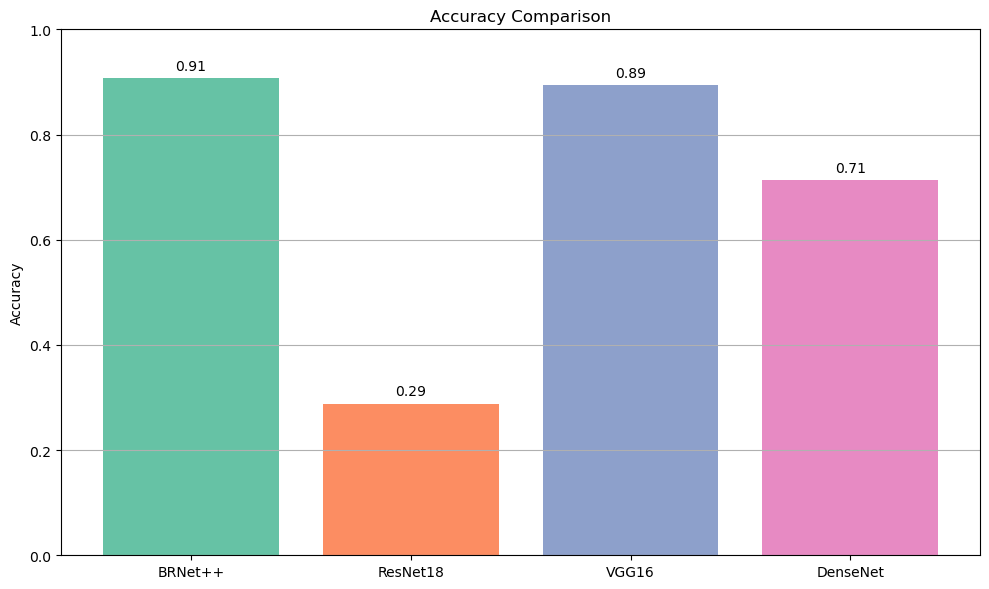

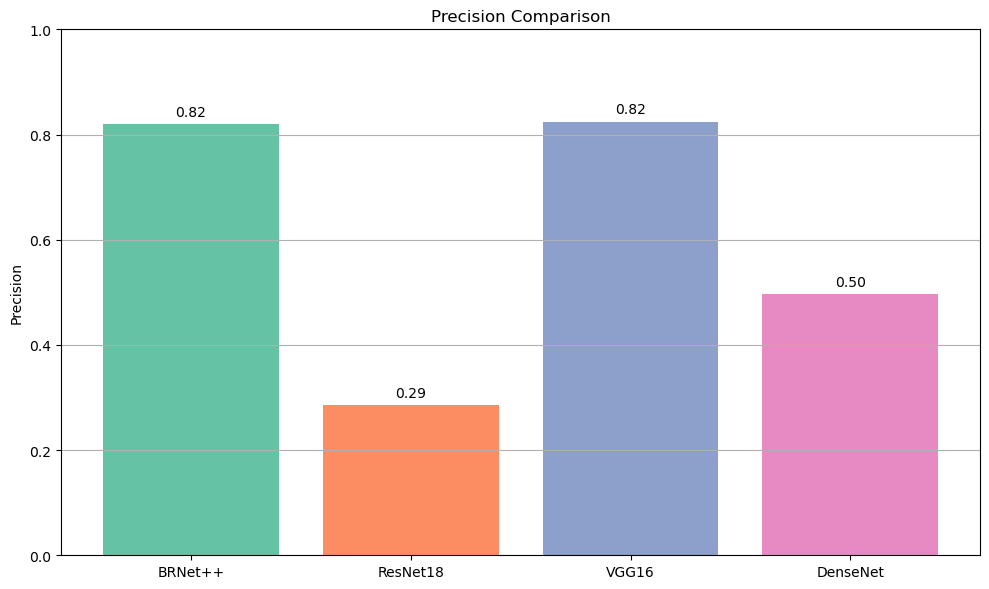

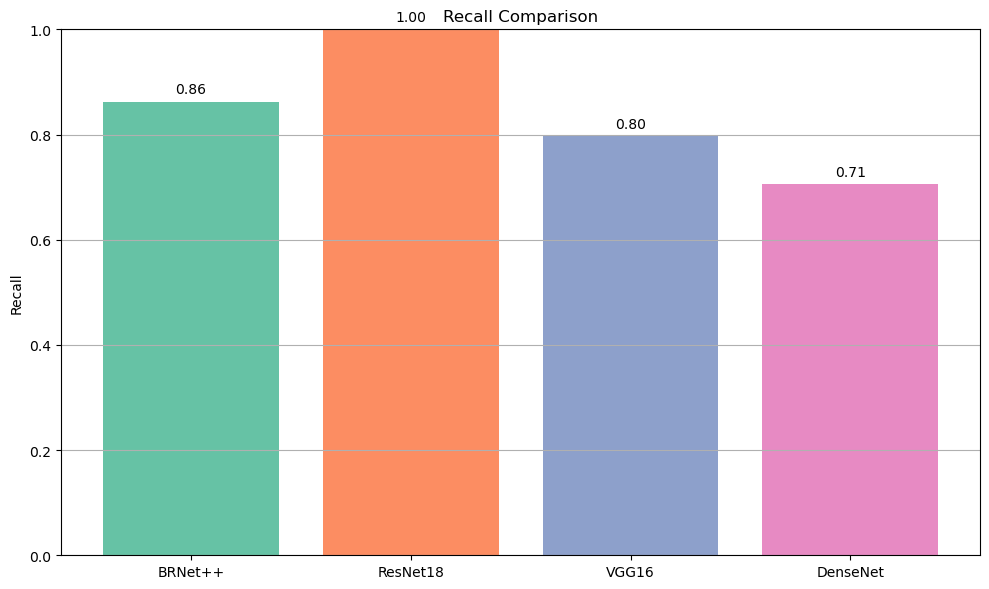

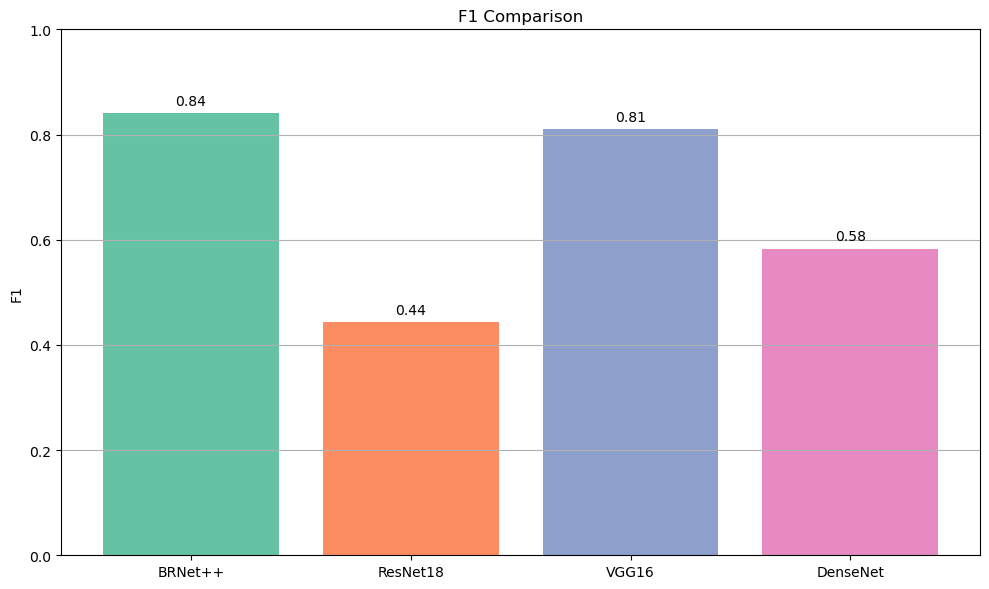

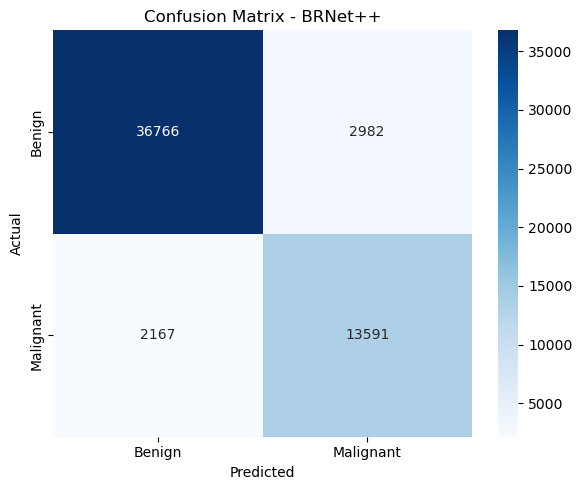

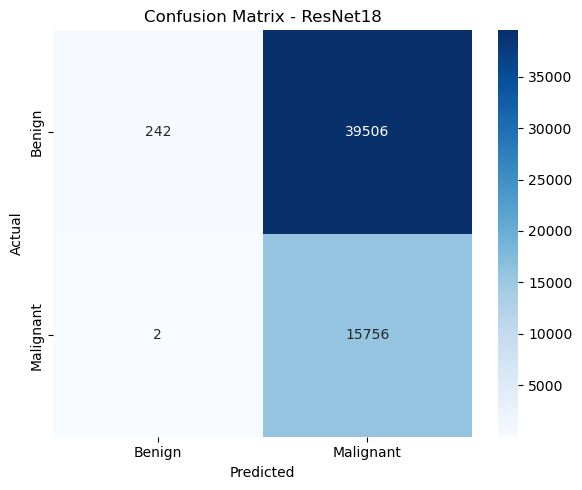

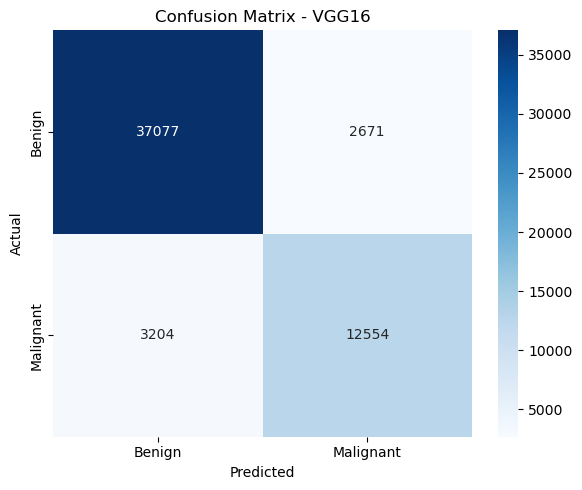

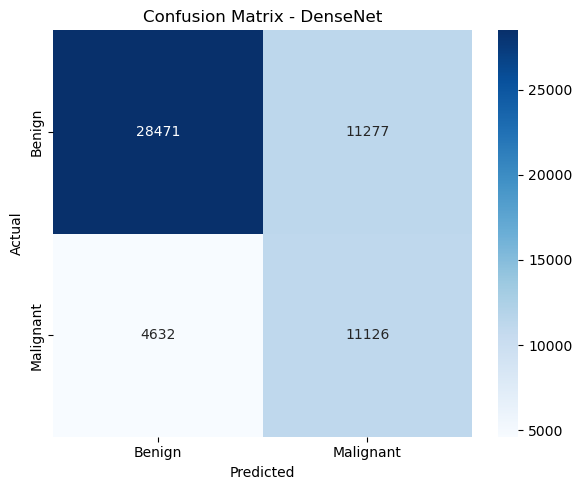

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_2892\980733692.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


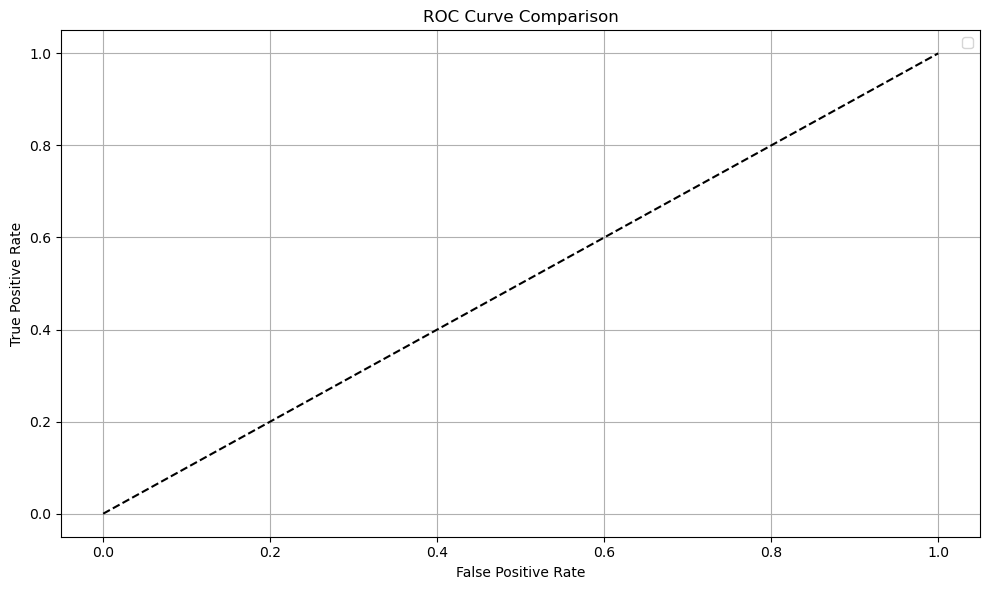

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_2892\980733692.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


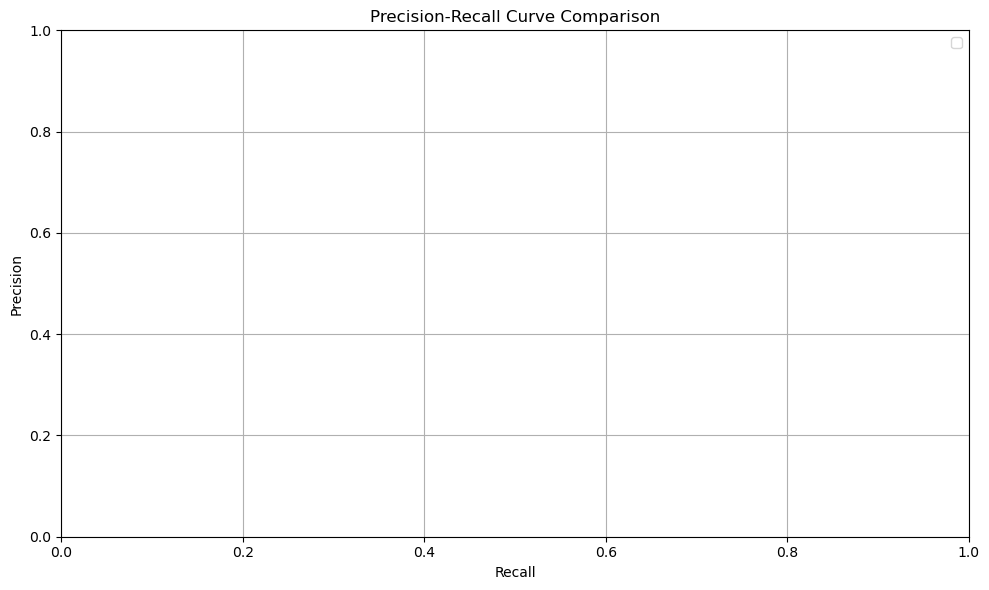

In [13]:

# Call this after populating your `results` dictionary:
plot_all_metrics(results)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def plot_without_probs(results_dict, class_names=["Benign", "Malignant"]):
    metrics = {
        "Model": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }

    # 👉 Bar chart metrics collection
    for model_name, data in results_dict.items():
        y_true = data['labels']
        y_pred = data['preds']

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        metrics["Model"].append(model_name)
        metrics["Accuracy"].append(acc)
        metrics["Precision"].append(prec)
        metrics["Recall"].append(rec)
        metrics["F1 Score"].append(f1)

        # 👉 Confusion matrix plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"{model_name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # 👉 Bar plot for all metrics
    x = np.arange(len(metrics["Model"]))
    width = 0.2

    plt.figure(figsize=(10, 6))
    plt.bar(x - 1.5 * width, metrics["Accuracy"], width, label='Accuracy')
    plt.bar(x - 0.5 * width, metrics["Precision"], width, label='Precision')
    plt.bar(x + 0.5 * width, metrics["Recall"], width, label='Recall')
    plt.bar(x + 1.5 * width, metrics["F1 Score"], width, label='F1 Score')

    # 📌 Annotate each bar with value
    for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1 Score"]):
        for j, val in enumerate(metrics[metric]):
            plt.text(j + (i - 1.5) * width, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)

    plt.xticks(x, metrics["Model"])
    plt.ylim(0, 1.1)
    plt.title("Model Comparison on Classification Metrics")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


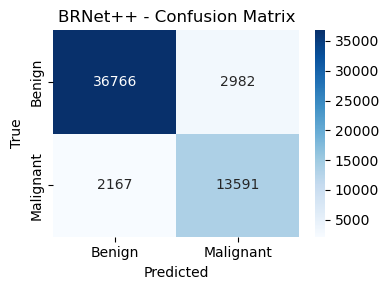

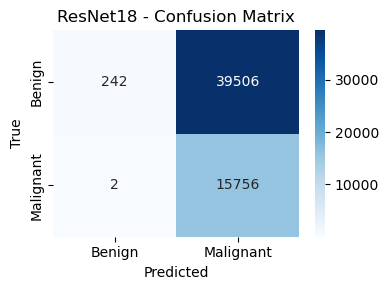

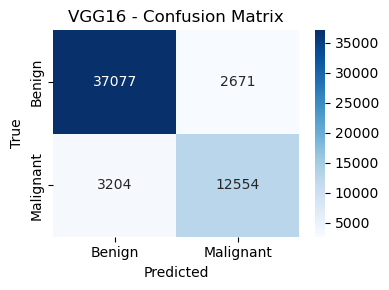

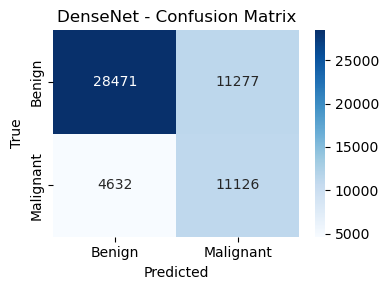

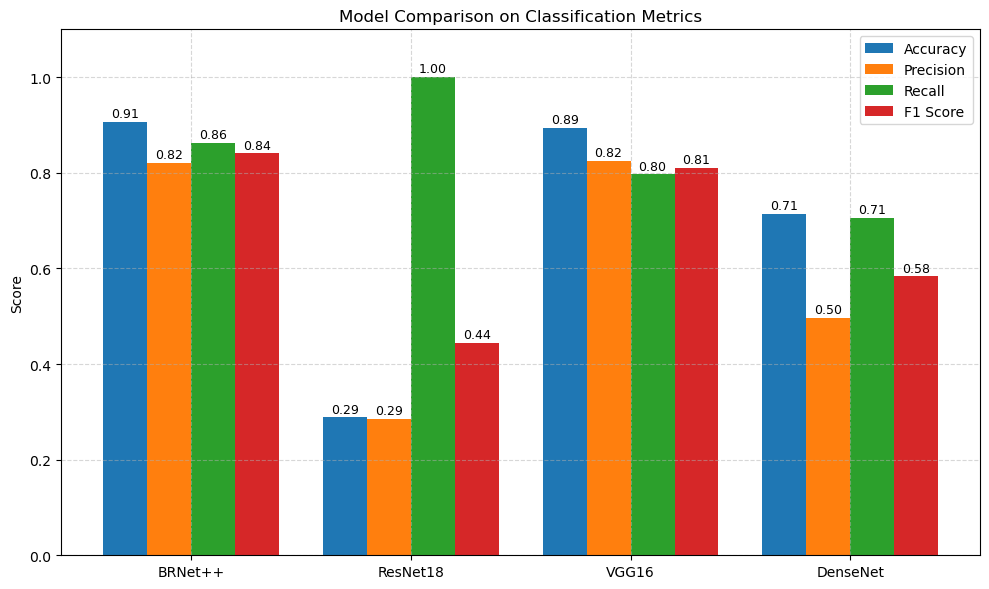

In [15]:
plot_without_probs(results)
